# Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchsummary import summary
import pandas as pd
import json
from PIL import Image

# Preparation of Dataset and Dataloader

### Preparation of filename-labels Pair

In [2]:
def prepare_filename_labels(data_type):
    """
    Returns dictionary with filename/labels pair
    ----------
    data_type : Str
                ("train" or "val")
                
    Returns
    ----------
        dictionary with a pair of filename/labels
    """
    with open(f"../../../fiftyone/coco-2014/raw/instances_{data_type}2014.json", 'r') as f:
        instances = json.load(f)
        
    images_dict = {}
    category_id = {}
    category = {}
    image_class_dict = {}
    file_labels = {}

    for image in instances["images"]:
        images_dict[image["id"]] = image["file_name"]
        
    for cat in instances["annotations"]:
        if cat["image_id"] in category_id.keys():
            category_id[cat["image_id"]].add(cat["category_id"])
        else:
            category_id[cat["image_id"]] = set([cat["category_id"]])
            
    for cat_id in instances["categories"]:
        category[cat_id["id"]] = cat_id["name"]
        
    for image_id, file_name in images_dict.items():
        if image_id in category_id.keys():
            for cat_id in list(category_id[image_id]):
                if file_name in image_class_dict.keys():
                    image_class_dict[file_name].append(category[cat_id])
                else:
                    image_class_dict[file_name] = [category[cat_id]]
        else:
            pass

    for image_id, index in category_id.items():
        index = list(index)
        temp = [0]*91
        for idx in index:
            temp[idx] = 1
        file_labels[images_dict[image_id]] = temp
        
    return file_labels, category

In [3]:
train_filename_labels, category = prepare_filename_labels("train")

In [4]:
val_filename_labels, category = prepare_filename_labels("val")

In [5]:
with open("../../../fiftyone/coco-2014/info.json", 'r') as file:
    info = json.load(file)

classes = tuple(info['classes'])

### Function to get index for 1 in category dictionary

In [6]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

### Preparation of Dataset Class

In [7]:
# Image transformations

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # # Test does not use augmentation
    # 'test':
    # transforms.Compose([
    #     transforms.Resize(size=256),
    #     transforms.CenterCrop(size=224),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406],
    #                          [0.229, 0.224, 0.225])
    # ])
}

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mode, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        file_name = os.listdir(self.img_dir)[idx]
        PIL_img = Image.open(img_path)
        image = PIL_img
        # image = ToTensor()(PIL_img)
        # image = image[0].unsqueeze(0)
        if self.mode == "train":
            label = np.array(train_filename_labels[file_name])
        if self.mode == "val":
            label = np.array(val_filename_labels[file_name])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
train_img_dir = "../../../fiftyone/coco-2014/train/data/"
val_img_dir = "../../../fiftyone/coco-2014/validation/data/"

In [10]:
BATCH_SIZE = 32

In [11]:
# Datasets from folders
data = {
    'train':
    CustomImageDataset(train_img_dir, "train", transform=image_transforms['train']),
    'valid':
    CustomImageDataset(val_img_dir, "val", transform=image_transforms['valid']),
    # 'test':
    # datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True),
    # 'test': DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True)
}

# Sample Check

In [12]:
# Iterate through the dataloader once
image, label = next(iter(dataloaders['train']))
image.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 91]))

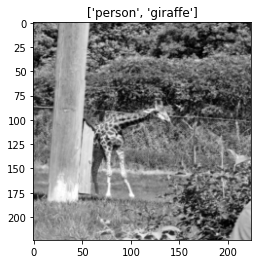

In [13]:
i = np.random.randint(0, 4)             # Choose one image at random
plt.imshow(image[i, 0], cmap='gray')    # Plot
plt.title([classes[label] for label in get_index_positions(list(label[i].numpy()), 1)])
plt.show()

# Pretrained Model

In [14]:
model = models.vgg16(pretrained=True)

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [17]:
# classifier of the pretrained model
# --> I am changing the 6th layer (i.e. classifier[6])
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [18]:
# Pretrained model
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

# Modify the Last Layer of the Classifier

In [19]:
# Constants for Last Layer

n_inputs = 4096
n_classes = len(classes)

In [20]:
n_classes

91

In [21]:
# Modify classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [22]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,332,763 total parameters.
1,072,219 training parameters.


# Moving Model to GPU

In [24]:
# Move to gpu
model = model.to('cuda')

In [25]:
device = torch.device("cuda")

# Prediction Function and Prediction Check before Training

In [26]:
def plot_prediction(image, label, predictions):
    """Plot network predictions with matplotlib."""
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)  # Plot
    ax1.imshow(image[0], cmap='gray')
    ax1.axis('off')   
    ax1.set_title([classes[lab] for lab in get_index_positions(list(label.numpy()), 1)])
    ax2.barh(np.arange(10), predictions[0][0].cpu().data.numpy().squeeze())
    ax2.set_title("Predictions")
    ax2.set_yticks(np.arange(10))
    ytick_classes = [classes[i] for i in predictions[1][0].cpu().data.numpy().squeeze()]
    ax2.set_yticklabels(ytick_classes)
    ax2.set_xlim(0, 1)
    plt.tight_layout();

In [27]:
# Test on training images (run as many times as you like!)
image, label = next(iter(dataloaders["train"]))        
model.to(device)
image = image.to(device)
label = label.to(device)
predictions = model(image)  # Get first image and predict it
predictions = nn.Softmax(dim=1)(predictions)  # Coerce predictions to probabilities using Softmax()
predictions = torch.topk(predictions, 10)
plot_prediction(image[0].cpu(), label[0].cpu(), predictions)

KeyError: 'COCO_train2014_000000321854.jpg'

# Training

In [ ]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}."
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
        
    print("\nTraining ended.")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [40]:
%%time

train_loss, valid_loss, train_accuracy, valid_accuracy = trainer(
    model, criterion, optimizer, dataloaders['train'], dataloaders['valid'], epochs=2, verbose=True
)

KeyError: 'COCO_train2014_000000309496.jpg'

# Examination of Losses and Accuracies

In [ ]:
loss_fig = pd.DataFrame(
    {"train_loss": train_loss, "valid_loss": valid_loss}
).plot.line()
loss_fig.set_xlabel('Epoch')
loss_fig.set_ylabel('Loss');

accur_fig = pd.DataFrame(
    {"train_accuracy": train_accuracy, 
     "valid_accuracy": valid_accuracy}
).plot.line()
accur_fig.set_xlabel('Epoch')
accur_fig.set_ylabel('Accuracy');

# Prediction Check After Training

In [ ]:
# Test on training images (run as many times as you like!)
image, label = next(iter(dataloaders["test"]))
model.to(device)
image = image.to(device)
label = label.to(device)
predictions = model(image)  # Get first image and predict it
predictions = nn.Softmax(dim=1)(predictions)  # Coerce predictions to probabilities using Softmax()
predictions = torch.topk(predictions, 10)
plot_prediction(image[0].cpu(), label[0].cpu(), predictions)

# Model Save

In [ ]:
torch.save(model.state_dict(), 'vgg16_multi_classification_model_weights.pth')
torch.save(model, 'vgg16_multi_classification_model.pth')